I was assigned some work earlier this year that required me to find all nodes in a directed graph that may be impacted by a change in some ancestor node.
The graph is relatively large—over 50,000 nodes—and my code had to complete in less than 300ms.
Long story short, I was able to complete this with my algorithm finishing closer to 40ms in a worst-case scenario.
Here's a rough version of the code:

In [1]:
from random import choice, seed

import networkx as nx  # 3.3
from networkx.drawing.nx_pydot import graphviz_layout

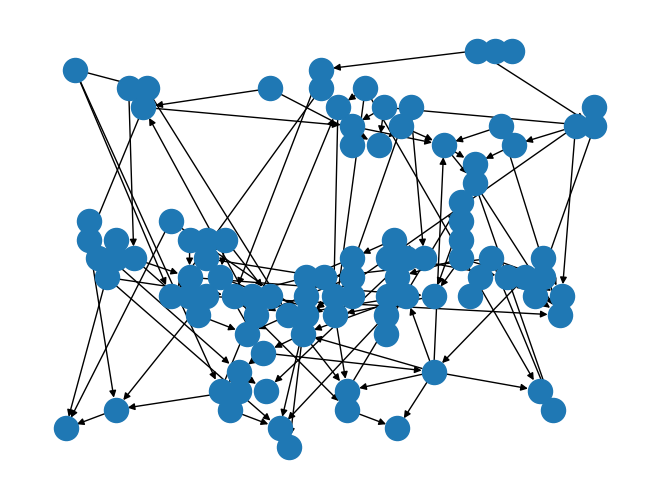

In [2]:
# Mock directed graph with 100 nodes and 1.5% chance of edge creation.
G = nx.gnp_random_graph(n=100, p=0.015, seed=0, directed=True)
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos)

In [3]:
# Normally I would extract ``source`` from an object, or it'd be provided.
seed(0)
source = choice([*G])

# Identify the descendants and return with mapping to ``source``
desc: set[int] = nx.descendants(G=G, source=source) | {source}
out: dict[int, set[int]] = {source: desc}
out

{49: {4,
  5,
  7,
  8,
  11,
  13,
  15,
  17,
  18,
  21,
  22,
  24,
  26,
  27,
  30,
  31,
  33,
  34,
  37,
  38,
  39,
  40,
  41,
  45,
  49,
  50,
  53,
  54,
  56,
  58,
  65,
  66,
  74,
  75,
  76,
  77,
  80,
  82,
  83,
  84,
  89,
  92,
  93,
  95,
  98}}

It's pretty straight forward.

In [4]:
%%timeit
desc: set[int] = nx.descendants(G=G, source=source) | {source}
out: dict[int, set[int]] = {source: desc}

16.9 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


And fast!
But what happens if we have multiple sources?
Per my stakeholders, they want all the results to be unioned together.
So rather than this:

In [5]:
def random_source(state: int) -> int:
    """Return a random node from ``G``."""
    seed(state)
    return choice([*G])


# Get more random source nodes.
sources = {random_source(state=i) for i in range(2)}
old: dict[int, set[int]] = {source: nx.descendants(G=G, source=source) | {source} for source in sources}

old

{49: {4,
  5,
  7,
  8,
  11,
  13,
  15,
  17,
  18,
  21,
  22,
  24,
  26,
  27,
  30,
  31,
  33,
  34,
  37,
  38,
  39,
  40,
  41,
  45,
  49,
  50,
  53,
  54,
  56,
  58,
  65,
  66,
  74,
  75,
  76,
  77,
  80,
  82,
  83,
  84,
  89,
  92,
  93,
  95,
  98},
 17: {7, 17, 31}}

They wanted this:

In [6]:
new: set[int] = set.union(*(nx.descendants(G=G, source=source) | {source} for source in sources))
new

{4,
 5,
 7,
 8,
 11,
 13,
 15,
 17,
 18,
 21,
 22,
 24,
 26,
 27,
 30,
 31,
 33,
 34,
 37,
 38,
 39,
 40,
 41,
 45,
 49,
 50,
 53,
 54,
 56,
 58,
 65,
 66,
 74,
 75,
 76,
 77,
 80,
 82,
 83,
 84,
 89,
 92,
 93,
 95,
 98}

Under the hood, the [`nx.descendants`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.descendants.html) algorithm runs a [Breadth-First Search (BFS)](https://en.wikipedia.org/wiki/Breadth-first_search) via the [`bfs_edges`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html) algorithm.
Looking at the source code, the `bfs_edges` algorithm uses the [`generic_bfs_edges`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.generic_bfs_edges.html) algorithm.

```python
# The original source code for ``generic_bfs_edges``.
def generic_bfs_edges(G, source, neighbors=None, depth_limit=None, sort_neighbors=None):
    """Taken from the following:
    
    https://networkx.org/documentation/stable/_modules/networkx/algorithms/traversal/breadth_first_search.html#generic_bfs_edges
    """
    if neighbors is None:
        neighbors = G.neighbors
    if sort_neighbors is not None:
        import warnings

        warnings.warn(
            (
                "The sort_neighbors parameter is deprecated and will be removed\n"
                "in NetworkX 3.4, use the neighbors parameter instead."
            ),
            DeprecationWarning,
            stacklevel=2,
        )
        _neighbors = neighbors
        neighbors = lambda node: iter(sort_neighbors(_neighbors(node)))
    if depth_limit is None:
        depth_limit = len(G)

    seen = {source}
    n = len(G)
    depth = 0
    next_parents_children = [(source, neighbors(source))]
    while next_parents_children and depth < depth_limit:
        this_parents_children = next_parents_children
        next_parents_children = []
        for parent, children in this_parents_children:
            for child in children:
                if child not in seen:
                    seen.add(child)
                    next_parents_children.append((child, neighbors(child)))
                    yield parent, child
            if len(seen) == n:
                return
        depth += 1
```

We can see that it takes a single `source`, but what if we could refactor it to take a collection of `source` nodes?
Would we see a speed up?
Let's find out.

In [7]:
from typing import Iterable


# The refactored source code for ``generic_bfs_edges``.
def generic_bfs_edges(
    G,
    sources: Iterable,  # changed.
    neighbors=None,
    depth_limit=None,
    sort_neighbors=None,
):
    """BFS with multiple sources."""
    if neighbors is None:
        neighbors = G.neighbors
    if sort_neighbors is not None:
        import warnings

        warnings.warn(
            (
                "The sort_neighbors parameter is deprecated and will be removed\n"
                "in NetworkX 3.4, use the neighbors parameter instead."
            ),
            DeprecationWarning,
            stacklevel=2,
        )
        _neighbors = neighbors
        neighbors = lambda node: iter(sort_neighbors(_neighbors(node)))
    if depth_limit is None:
        depth_limit = len(G)

    seen = {*sources}  # changed.
    n = len(G)
    depth = 0
    for source in sources:  # changed.
        next_parents_children = [(source, neighbors(source))]
        while next_parents_children and depth < depth_limit:
            this_parents_children = next_parents_children
            next_parents_children = []
            for parent, children in this_parents_children:
                for child in children:
                    if child not in seen:
                        seen.add(child)
                        next_parents_children.append((child, neighbors(child)))
                        yield parent, child
                if len(seen) == n:
                    return
        depth += 1

And now for some tests.
First, is the output the same?

In [8]:
# When ``source`` is 49.
out[source] - {source} == {child for parent, child in generic_bfs_edges(G=G, sources=[source], neighbors=G.neighbors)}

True

Second, did we get any faster?

In [9]:
%%timeit
original: set[int] = set.union(*(nx.descendants(G=G, source=source) | {source} for source in sources))

21.1 µs ± 839 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
proposed: set[int] = {child for parent, child in generic_bfs_edges(G=G, sources=sources, neighbors=G.neighbors)}

13.7 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Would you look at that; it's faster!

In [11]:
f"{(13.7 - 21.1) / 21.1:.2%}"

'-35.07%'

Approximately 35% faster. If we make the graph larger does this hold?

In [12]:
# Mock directed graph with 1,000 nodes.
G = nx.gnp_random_graph(n=1_000, p=0.0015, seed=0, directed=True)
# Two random sources
sources = {random_source(state=i) for i in range(2)}

In [13]:
%%timeit
original: set[int] = set.union(*(nx.descendants(G=G, source=source) | {source} for source in sources))

203 µs ± 2.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
proposed: set[int] = {child for parent, child in generic_bfs_edges(G=G, sources=sources, neighbors=G.neighbors)}

183 µs ± 9.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
f"{(183 - 203) / 203:.2%}"

'-9.85%'

Eh, we lose a bit on the percentage side, but it's still promising.
Now for the final test—50,000 nodes.

In [16]:
# Mock directed graph with 50,000 nodes.
G = nx.gnp_random_graph(n=50_000, p=1.5/50_000, seed=0, directed=True)  # WARNING! This takes a while to build.
# Two random sources
sources = {random_source(state=i) for i in range(2)}

In [17]:
%%timeit
original: set[int] = set.union(*(nx.descendants(G=G, source=source) | {source} for source in sources))

48.5 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
proposed: set[int] = {child for parent, child in generic_bfs_edges(G=G, sources=sources, neighbors=G.neighbors)}

22 ms ± 842 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
f"{(22 - 48.5) / 48.5:.2%}"

'-54.64%'

I think we have enough evidence to say that the multi-source bfs algorithm is worth using in my project. 😎